In [1]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape, Merge
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
from PIL import Image
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
import math
import copy
os.environ['PYTHONASHSEED']= '0'

Using TensorFlow backend.


In [2]:
import os
classes_name = []
files_name = []
for root, dirs, files in os.walk('Dataset1/train_data'):  
    for name in dirs:
        classes_name.append(name)
    for name1 in files:
        files_name.append(name1)

print(len(classes_name))
print(len(files_name))



2
321


In [3]:
# ########### Define  function to split  dataset #######################

# import shutil, sys  
# def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    
#     if not os.path.exists(training_data_dir):
#         os.makedirs(training_data_dir)
#     if not os.path.exists(testing_data_dir):
#         os.makedirs(testing_data_dir)
#     # Recreate testing and training directories
#     if testing_data_dir.count('/') > 1:
#         shutil.rmtree(testing_data_dir, ignore_errors=False)
#         os.makedirs(testing_data_dir)
#         print("Successfully cleaned directory " + testing_data_dir)
#     else:
#         print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

#     if training_data_dir.count('/') > 1:
#         shutil.rmtree(training_data_dir, ignore_errors=False)
#         os.makedirs(training_data_dir)
#         print("Successfully cleaned directory " + training_data_dir)
#     else:
#         print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

#     num_training_files = 0
#     num_testing_files = 0

#     for subdir, dirs, files in os.walk(all_data_dir):
#         category_name = os.path.basename(subdir)                        ### find  name  of classes

#         # Don't create a subdirectory for the root directory
#         print(category_name + " vs " + os.path.basename(all_data_dir))
#         if category_name == os.path.basename(all_data_dir):
#             continue

#         training_data_category_dir = training_data_dir + '/' + category_name
#         testing_data_category_dir = testing_data_dir + '/' + category_name

#         if not os.path.exists(training_data_category_dir):
#             os.mkdir(training_data_category_dir)

#         if not os.path.exists(testing_data_category_dir):
#             os.mkdir(testing_data_category_dir)

#         for file in files:
#             input_file = os.path.join(subdir, file)
#             if np.random.rand(1) < testing_data_pct:
#                 shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
#                 num_testing_files += 1
#             else:
#                 shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
#                 num_training_files += 1

#     print("Processed " + str(num_training_files) + " training files.")
#     print("Processed " + str(num_testing_files) + " testing files.")

In [4]:
##### Split data into train_data and test data
# split_dataset_into_test_and_train_sets('Data2','Dataset2/train_data', 'Dataset2/test_data', 0.2)

In [5]:
##### calculate  number of images
import os
classes_name_train = []
files_name_train = []
classes_name_test = []
files_name_test = []
for root, dirs, files in os.walk('Dataset1/train_data'):  
    for name in dirs:
        classes_name_train.append(name)
    for name1 in files:
        files_name_train.append(name1)
        
for root, dirs, files in os.walk('Dataset1/test_data'):  
    for name in dirs:
        classes_name_test.append(name)
    for name1 in files:
        files_name_test.append(name1)

no_training = len(files_name_train)
no_testing = len(files_name_test)
        
print(len(classes_name_train))
print(len(files_name_train))
print(len(classes_name_test))
print(len(files_name_test))
number_classes = len(classes_name_train)

2
321
2
79


In [6]:
# data_generator = ImageDataGenerator(
#                         featurewise_center=False,
#                         featurewise_std_normalization=False,
#                         rotation_range=10,
#                         width_shift_range=0.1,
#                         height_shift_range=0.1,
#                         zoom_range=.1,
#                         horizontal_flip=True)

In [7]:
#### set parameters
batch_size = 8
n_epochs= 500

In [8]:
train_path = 'Dataset1/train_data'
test_path = 'Dataset1/test_data'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = classes_name, batch_size = batch_size)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = classes_name, batch_size = batch_size)

Found 321 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [9]:

# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()

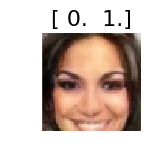

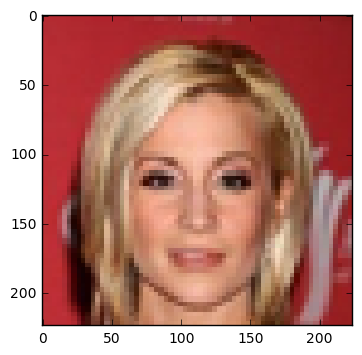

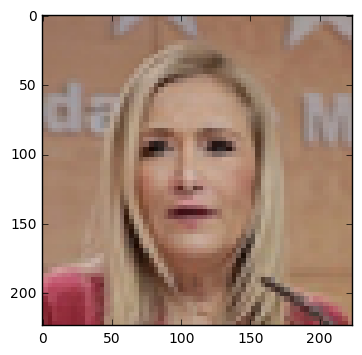

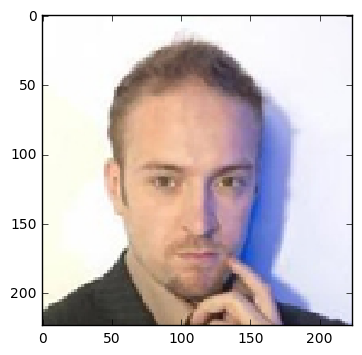

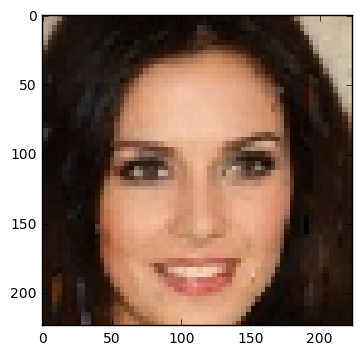

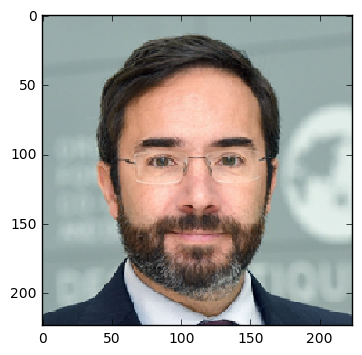

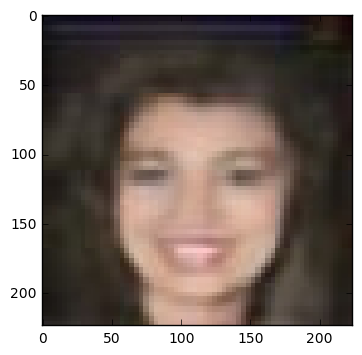

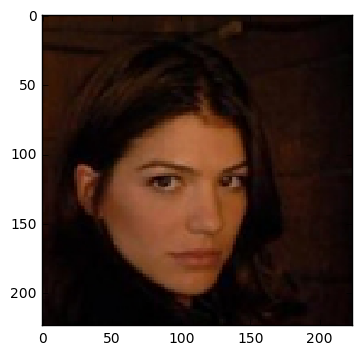

In [10]:
imgs, labels = next(train_batches)
plots(imgs, titles = labels)

In [11]:

######### fine_tune vgg_face 
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [12]:
def vgg_face_blank():
    
    withDO = True # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        #mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') ) # Keras 1
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [13]:
facemodel = vgg_face_blank()

In [14]:
facemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [15]:
model = Sequential()
for layer in facemodel.layers:
    model.add(layer)

In [16]:
from scipy.io import loadmat
data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description

In [17]:

def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print(matname, mattype)
            print(l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape)
            print(kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape)
            print('------------------------------------------')
        else:
            print('MISSING : ', matname, mattype)
            print('------------------------------------------')

In [18]:

def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            #f_l_weights = np.flip(f_l_weights, 2) # INFO : for 'th' setting in dim_ordering
            #f_l_weights = np.flip(f_l_weights, 3) # INFO : for 'th' setting in dim_ordering
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [19]:
copy_mat_to_keras(model)

In [20]:
## remove  last layer  of  vgg_face 
model.layers.pop() 
# model.summary()

In [21]:
### add SVM in the  last layer
from keras import regularizers
model.add(Dense(2, activation = 'linear', kernel_regularizer=regularizers.l2(0.001)))

#### set trainable layer  
#for layer in model.layers:
#    layer.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [22]:
n = len(model.layers)
for idx, layer in enumerate(model.layers):
    if idx < (n-2): 
           layer.trainable = False
    else:
           layer.trainable = True

In [23]:
##### compile with SGD
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])

#### compile with Adam 
opt = Adam(lr=0.001, decay=10e-6)
model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

#model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

In [24]:

### training    
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "vggface1.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = model.fit_generator(train_batches, steps_per_epoch = int(no_training / batch_size), validation_data = test_batches, validation_steps = int(no_testing / batch_size), epochs = n_epochs, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/500
 - 4s - loss: 0.9913 - acc: 0.4528 - val_loss: 0.9775 - val_acc: 0.5972

Epoch 00001: val_acc improved from -inf to 0.59722, saving model to vggface1.weights.best.hdf5
Epoch 2/500
 - 2s - loss: 0.9674 - acc: 0.5472 - val_loss: 0.9560 - val_acc: 0.5556

Epoch 00002: val_acc did not improve
Epoch 3/500
 - 3s - loss: 0.9458 - acc: 0.5909 - val_loss: 0.9355 - val_acc: 0.5833

Epoch 00003: val_acc did not improve
Epoch 4/500
 - 2s - loss: 0.9242 - acc: 0.6467 - val_loss: 0.9154 - val_acc: 0.6667

Epoch 00004: val_acc improved from 0.59722 to 0.66667, saving model to vggface1.weights.best.hdf5
Epoch 5/500
 - 2s - loss: 0.9035 - acc: 0.6811 - val_loss: 0.8953 - val_acc: 0.7083

Epoch 00005: val_acc improved from 0.66667 to 0.70833, saving model to vggface1.weights.best.hdf5
Epoch 6/500
 - 2s - loss: 0.8833 - acc: 0.7123 - val_loss: 0.8759 - val_acc: 0.7083

Epoch 00006: val_acc did not improve
Epoch 7/500
 - 2s - loss: 0.8626 - acc: 0.7375 - val_loss: 0.8559 - val_acc: 0.7083

Epo

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])


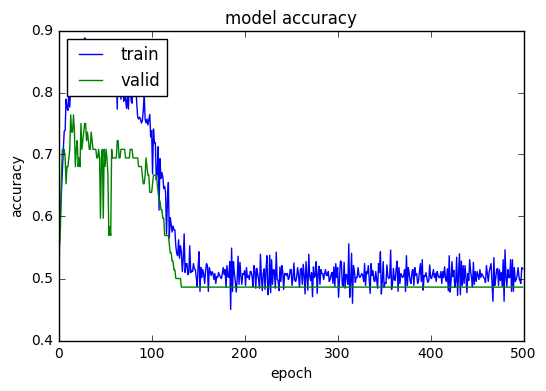

In [25]:

# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()